In [1]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(r"C:\Users\Admin\Desktop\DATA EXERCISES\Data Cleaning\515K Hotel Reviews Dataset\Hotel_Reviews_Cleaned.csv", engine="python") 

Objective: Find trends across the years on the relationship between attributes and people's general sentiments

EDA Goals:
- Understand structure of data
- Identifying target variable and correlating attributes
- Detect patterns, trends, anomalies

Checklist:

Data cleaning step is finished. Analysis part should consist:
- Distributions
- Relationships Between Variables
    - (num vs num) 
    - (num vs cat)
- Time Trends
    - rolling averages
    - trends per attribute
    - sentiment seasonality by day of week, month, year

In [2]:
data["Review_Date"] = pd.to_datetime(data["Review_Date"], errors="coerce")
data = data.sort_values("Review_Date")
cat_cols = ["Hotel_Name", "Reviewer_Nationality", "Trip_Type", "Group"]
data[cat_cols] = data[cat_cols].astype("category")
print("Missing Data: ", data.isna().sum())

Missing Data:  Additional_Number_of_Scoring                   0
Review_Date                                    0
Average_Score                                  0
Hotel_Name                                     0
Reviewer_Nationality                           0
Total_Number_of_Reviews                        0
Total_Number_of_Reviews_Reviewer_Has_Given     0
Reviewer_Score                                 0
Days_Since_Review                              0
Review                                        59
Trip_Type                                      0
Group                                          0
Stayed_Nights                                  0
dtype: int64


In [3]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515142 entries, 417416 to 0
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                515142 non-null  int64         
 1   Review_Date                                 515142 non-null  datetime64[ns]
 2   Average_Score                               515142 non-null  float64       
 3   Hotel_Name                                  515142 non-null  category      
 4   Reviewer_Nationality                        515142 non-null  category      
 5   Total_Number_of_Reviews                     515142 non-null  int64         
 6   Total_Number_of_Reviews_Reviewer_Has_Given  515142 non-null  int64         
 7   Reviewer_Score                              515142 non-null  float64       
 8   Days_Since_Review                           515142 non-null  int64         
 9 

In [4]:
data.describe()

,Additional_Number_of_Scoring,Review_Date,Average_Score,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Stayed_Nights
count,515142.000000,515142,515142.000000,515142.000000,515142.000000,515142.000000,515142.000000,515142.000000
mean,498.414670,2016-08-13 14:14:12.440686080,8.397774,2744.679366,7.164731,8.395555,3389.406800,2.361883
min,1.000000,2015-08-04 00:00:00,5.200000,43.000000,1.000000,2.500000,3035.000000,1.000000
25%,169.000000,2016-02-23 00:00:00,8.100000,1161.000000,1.000000,7.500000,3210.000000,1.000000
50%,342.000000,2016-08-15 00:00:00,8.400000,2134.000000,3.000000,8.800000,3388.000000,2.000000
75%,660.000000,2017-02-09 00:00:00,8.800000,3633.000000,8.000000,9.600000,3562.000000,3.000000
max,2682.000000,2017-08-03 00:00:00,9.800000,16670.000000,355.000000,10.000000,3765.000000,31.000000
std,500.664997,NaN,0.547952,2318.051806,11.039448,1.637437,208.911604,1.646628


Part 1. Sentiment Analysis
Utilize VADER to convert sentiments into a score between -1 and +1 creating sentiment label as target variable

In [5]:
import sys
!{sys.executable} -m pip install nltk



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(text): # function to apply to the sentiment column
    score = sia.polarity_scores(text)["compound"]
    return score

data["Sentiment_Compound"] = data["Review"].astype(str).apply(get_sentiment)

# labeling sentiment
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"
data["Sentiment_Label"] = data["Sentiment_Compound"].astype(float).apply(label_sentiment)
data["Sentiment_Label"] = data["Sentiment_Label"].astype("category")

Setting index using review date for analysis. 

In [ ]:
data = data.set_index(data["Review_Date"])

Taking a look at the dataset's distribution of sentiment classes in general and grouped by years. 

C:\Users\Admin\AppData\Local\Temp\ipykernel_1584\463045275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Sentiment_Label", palette=colours)


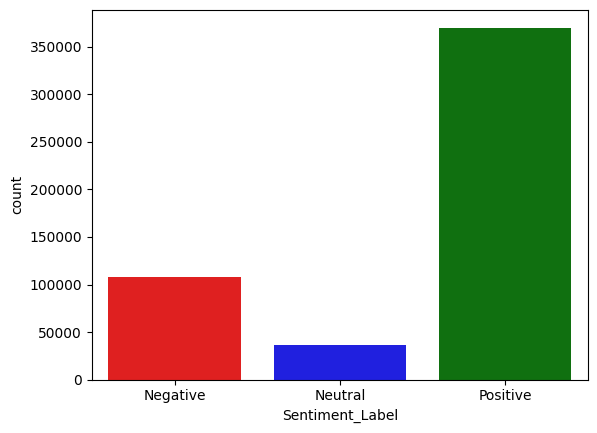

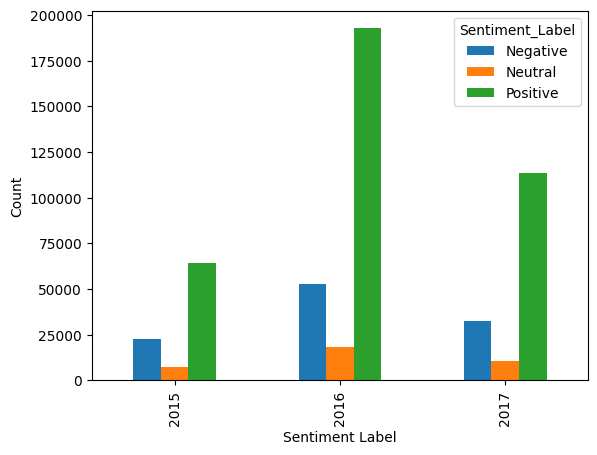

In [71]:
import seaborn as sns
colours = ["r", "b", "g"]
sns.countplot(data=data, x="Sentiment_Label", palette=colours)
data["Sentiment_Label"].value_counts(normalize=True) * 100


data["Sentiment_Label"].groupby(data.index.year).value_counts().unstack().plot.bar(xlabel="Sentiment Label", ylabel="Count")
plt.show()


- Disproportionate data, high likelihood of generating misleading classification accuracy.
- Positive language dominates customers' reviews.
- 2016 with highest counts of reviews suggesting artifial disproportion as a result of lack of timeframe coverage for 2015 and 2017 within the dataset.

Phase 2: Relationship Between Attributes

A: Numeric <-> Numeric

    - Pearson Correlation
    - Spearman Correlation
    - Heatmap

B: Cetegorical <-> Numeric

    - ANOVA
    - Violin plots
    - Groupby means
    

C: Categorical <-> Categorical

    - Chi-Square tests
    - Proportion plots

D: Numeric <-> Time

    - Rolling averages
    - Seasonal
    - Heatmap

A. NUMERIC <-> NUMERIC

Mapping sentiment using numbers. Negative: 0, Neutral: 1, Positive: 2

In [72]:
sentiment_map = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

data["Sentiment_Label_Int"] = data["Sentiment_Label"].map(sentiment_map).astype("int")


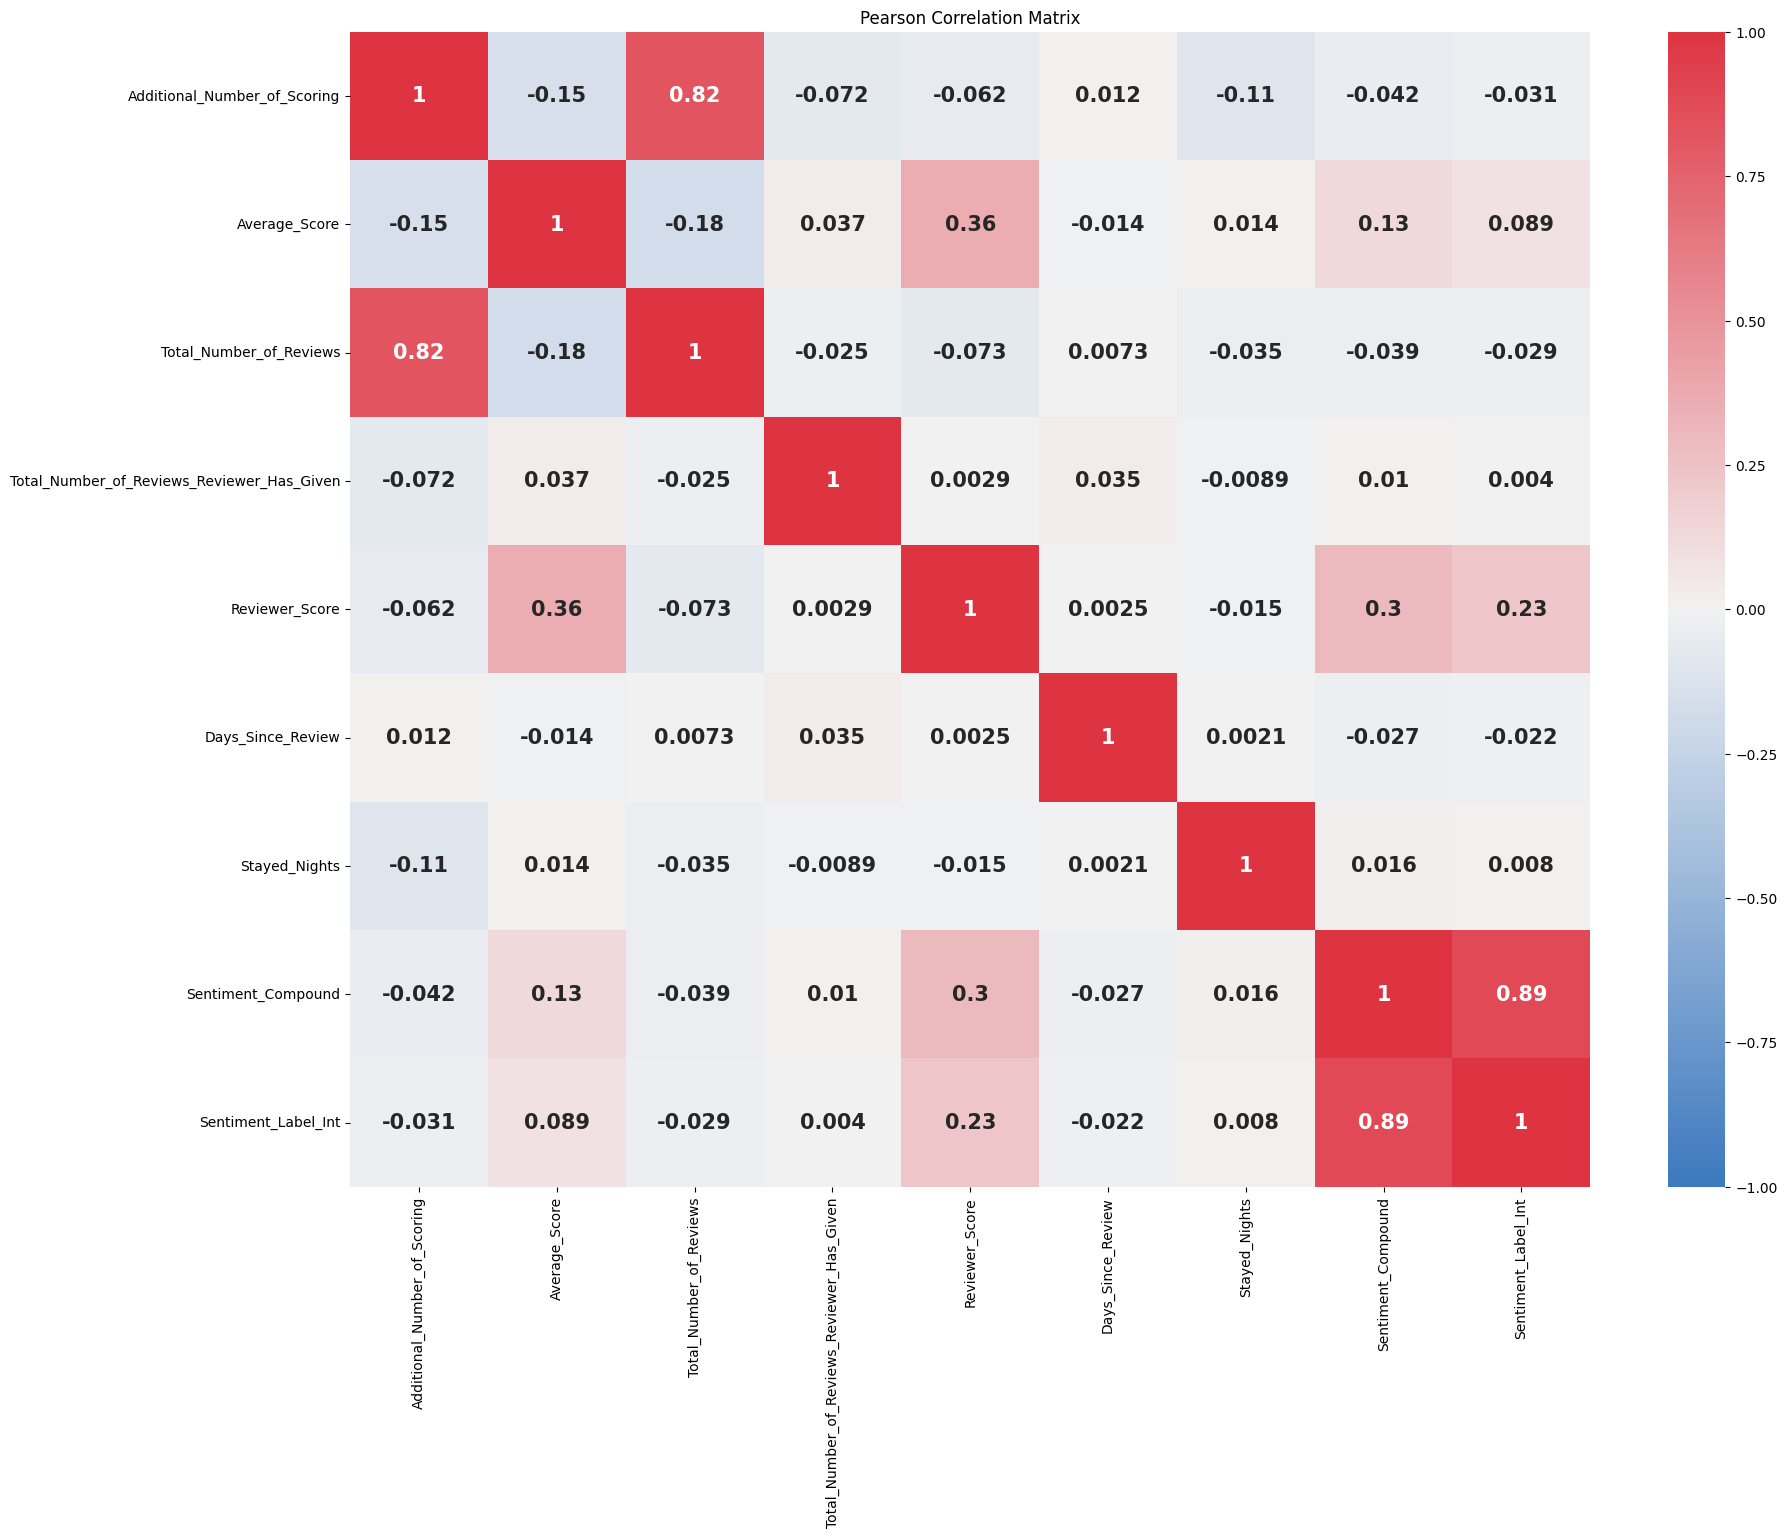

,Additional_Number_of_Scoring,Average_Score,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Stayed_Nights,Sentiment_Compound,Sentiment_Label_Int
Additional_Number_of_Scoring,1.000000,-0.153223,0.824911,-0.071954,-0.061735,0.011975,-0.109142,-0.042210,-0.030632
Average_Score,-0.153223,1.000000,-0.179673,0.036518,0.364179,-0.014029,0.013777,0.127666,0.089010
Total_Number_of_Reviews,0.824911,-0.179673,1.000000,-0.024905,-0.072891,0.007262,-0.034927,-0.039054,-0.028758
Total_Number_of_Reviews_Reviewer_Has_Given,-0.071954,0.036518,-0.024905,1.000000,0.002873,0.035120,-0.008946,0.010375,0.004020
Reviewer_Score,-0.061735,0.364179,-0.072891,0.002873,1.000000,0.002475,-0.014810,0.302015,0.227049
Days_Since_Review,0.011975,-0.014029,0.007262,0.035120,0.002475,1.000000,0.002091,-0.026929,-0.022342
Stayed_Nights,-0.109142,0.013777,-0.034927,-0.008946,-0.014810,0.002091,1.000000,0.016486,0.008002
Sentiment_Compound,-0.042210,0.127666,-0.039054,0.010375,0.302015,-0.026929,0.016486,1.000000,0.887043
Sentiment_Label_Int,-0.030632,0.089010,-0.028758,0.004020,0.227049,-0.022342,0.008002,0.887043,1.000000


In [73]:
num_data = data.select_dtypes(["float64", "int64"])
pearson_corr = num_data.corr(method="pearson")
cmap = sns.diverging_palette(250, 10, s=80, l=50, n=9, as_cmap=True)
font = {"fontsize": 15, "fontweight": "bold"}
plt.figure(figsize=(20,15))
sns.heatmap(
    pearson_corr,
    annot=True,
    cmap=cmap,
    center=0,
    vmax=1,
    vmin=-1,
    annot_kws=font
)
plt.title("Pearson Correlation Matrix")
plt.show()

pearson_corr

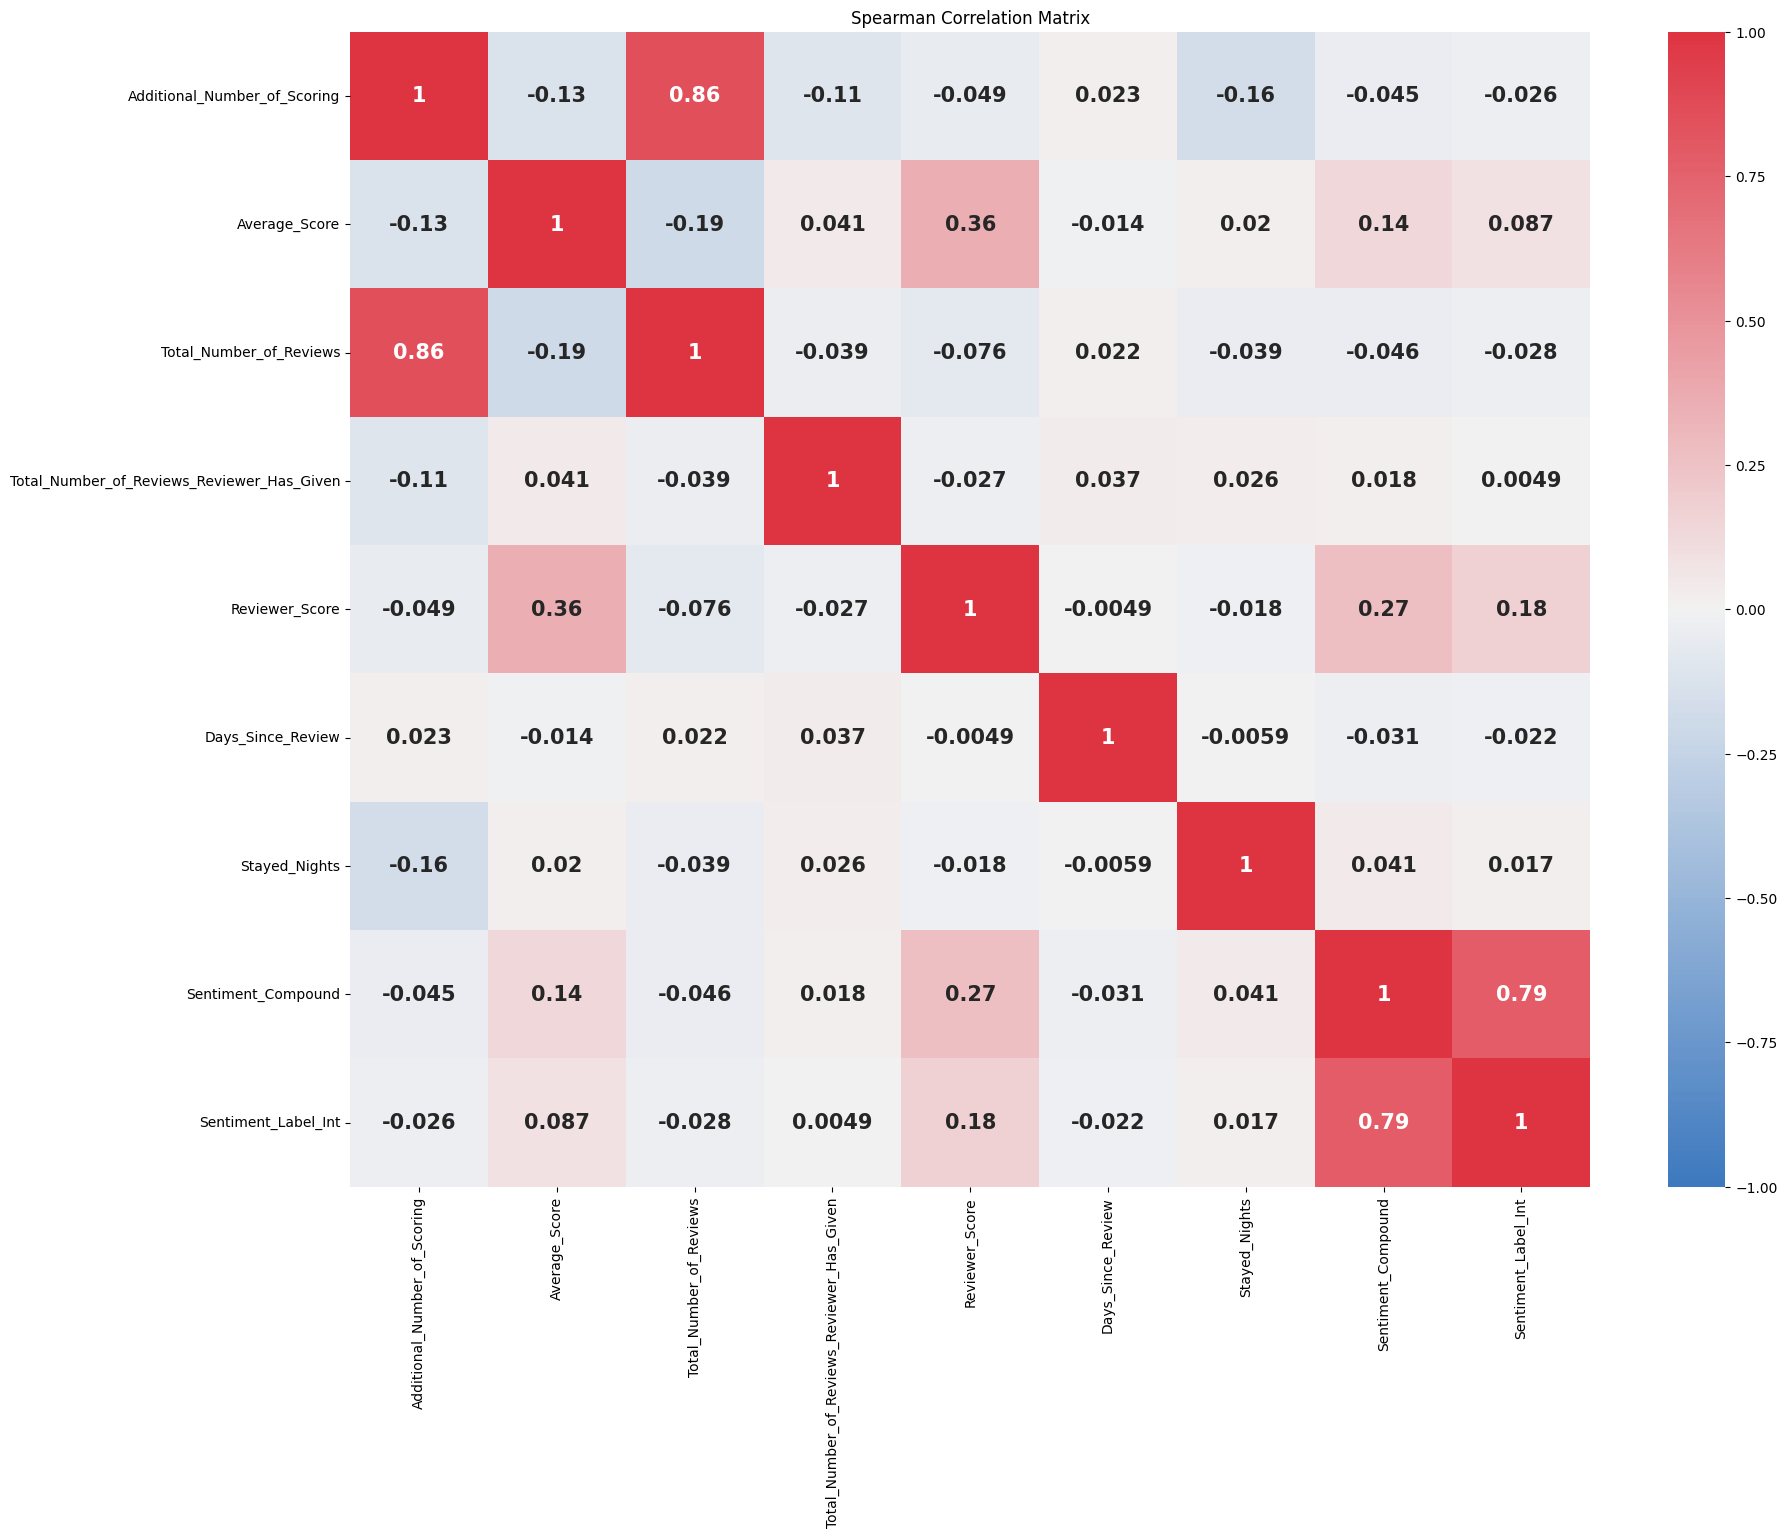

,Additional_Number_of_Scoring,Average_Score,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Stayed_Nights,Sentiment_Compound,Sentiment_Label_Int
Additional_Number_of_Scoring,1.000000,-0.128415,0.859136,-0.105404,-0.049373,0.023196,-0.164188,-0.045219,-0.025588
Average_Score,-0.128415,1.000000,-0.193158,0.040858,0.356880,-0.014104,0.020264,0.138666,0.086847
Total_Number_of_Reviews,0.859136,-0.193158,1.000000,-0.038671,-0.076420,0.021628,-0.039175,-0.045553,-0.028494
Total_Number_of_Reviews_Reviewer_Has_Given,-0.105404,0.040858,-0.038671,1.000000,-0.026548,0.036696,0.025658,0.018305,0.004896
Reviewer_Score,-0.049373,0.356880,-0.076420,-0.026548,1.000000,-0.004895,-0.017753,0.269118,0.178475
Days_Since_Review,0.023196,-0.014104,0.021628,0.036696,-0.004895,1.000000,-0.005883,-0.030505,-0.021691
Stayed_Nights,-0.164188,0.020264,-0.039175,0.025658,-0.017753,-0.005883,1.000000,0.040514,0.017422
Sentiment_Compound,-0.045219,0.138666,-0.045553,0.018305,0.269118,-0.030505,0.040514,1.000000,0.786923
Sentiment_Label_Int,-0.025588,0.086847,-0.028494,0.004896,0.178475,-0.021691,0.017422,0.786923,1.000000


In [74]:
spearman_corr = num_data.corr(method="spearman")
plt.figure(figsize=(20, 15))
sns.heatmap(
    spearman_corr,
    annot=True,
    cmap=cmap,
    center=0,
    vmax=1,
    vmin=-1,
    annot_kws=font
)
plt.title("Spearman Correlation Matrix")
plt.show()
spearman_corr

Additional Scoring vs. Total Reviews (r = 0.86): Strong positive relationship, indicating higher review volume is associated with more scoring activity.

Average Score vs. Reviewer Score (r = 0.36): Moderate alignment, suggesting reviewers loosely follow existing average ratings.

Reviewer Score vs. Sentiment (r = 0.27): Weak–moderate relationship, showing text sentiment only partially reflects numerical scores.


B. NUMERIC <-> CATEGORICAL

Leveraging ANOVA to test if mean values of numerical variables differ across sentiment categories

Null Hypothesis (H₀): There is no statistically significant difference in the mean values of the numerical feature across sentiment categories.

In [75]:
from scipy.stats import f_oneway

anova_results = {}

for col in num_data:
    groups = [group[col].values for name, group in data.groupby("Sentiment_Label")]
    f_stat, p_val = f_oneway(*groups)
    anova_results[col] = {"F-statistic": f_stat, "p-value": p_val}

anova_df = pd.DataFrame(anova_results).T.sort_values("p-value")
print(anova_df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1584\1001675907.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[col].values for name, group in data.groupby("Sentiment_Label")]


                                             F-statistic        p-value
Average_Score                               2.153247e+03   0.000000e+00
Reviewer_Score                              1.422065e+04   0.000000e+00
Sentiment_Compound                          9.665222e+05   0.000000e+00
Sentiment_Label_Int                                  inf   0.000000e+00
Additional_Number_of_Scoring                2.716234e+02  1.252036e-118
Total_Number_of_Reviews                     2.267002e+02   3.878504e-99
Days_Since_Review                           1.367243e+02   4.336716e-60
Stayed_Nights                               5.501359e+01   1.289599e-24
Total_Number_of_Reviews_Reviewer_Has_Given  9.371688e+00   8.511412e-05


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


- One-way ANOVA results indicate statistically significant differences in the mean values of most numerical features across sentiment categories (p < 0.05) - Reject null hypothesis

- Statistical significance sould be interpreted alongside effect size and visual analysis, given the large sample size.

- Sentiment Label Int yields an infinite F-statistic as it directly encodes target class and is excluded from interpretation.

Variance between sentiment groups is much larger than within groups for:

    - Additional Number of Scoring
    - Total Number of Reviews
    - Days Since Review
    - Stayed Nights
    - Total Number of Reviews Reviewer Has Given

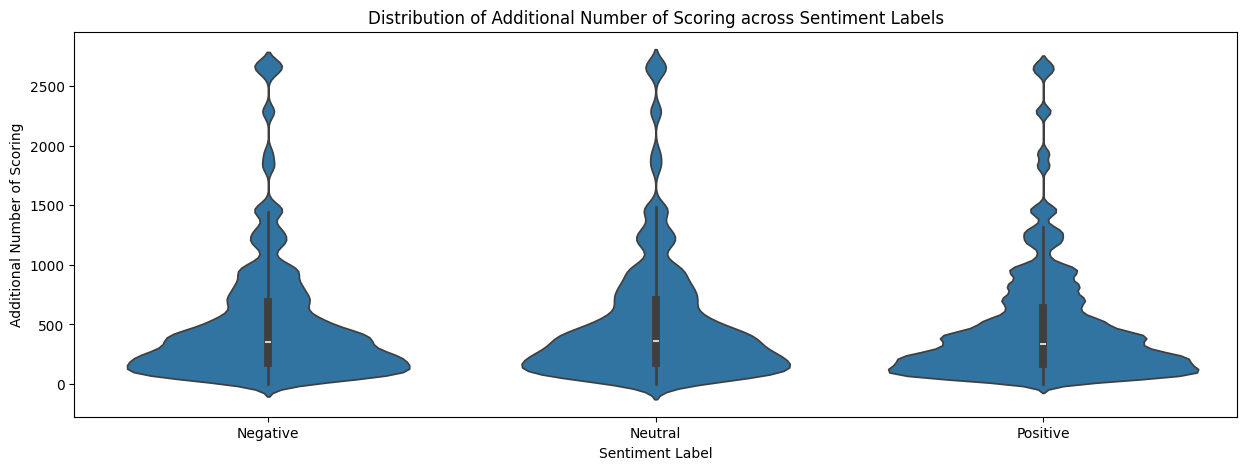

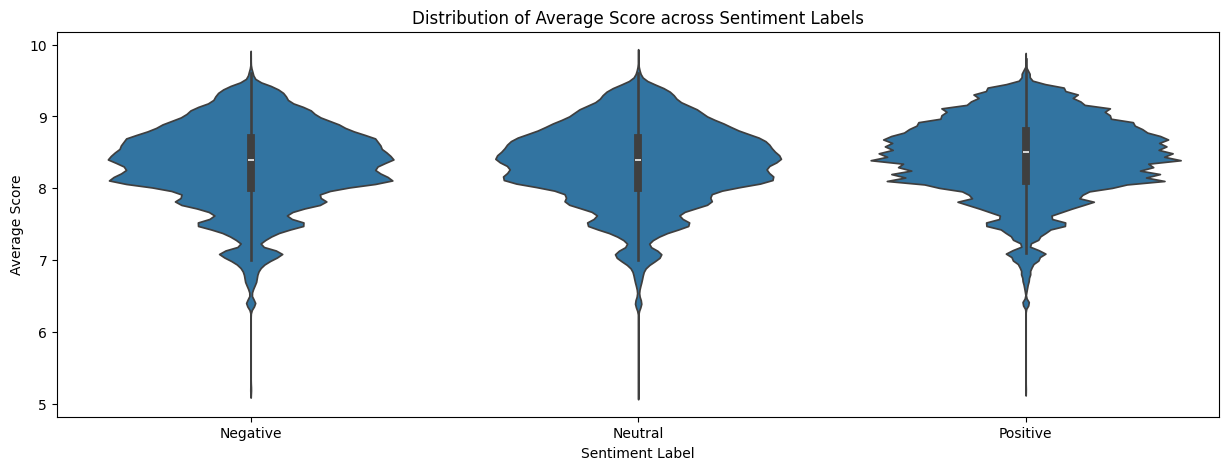

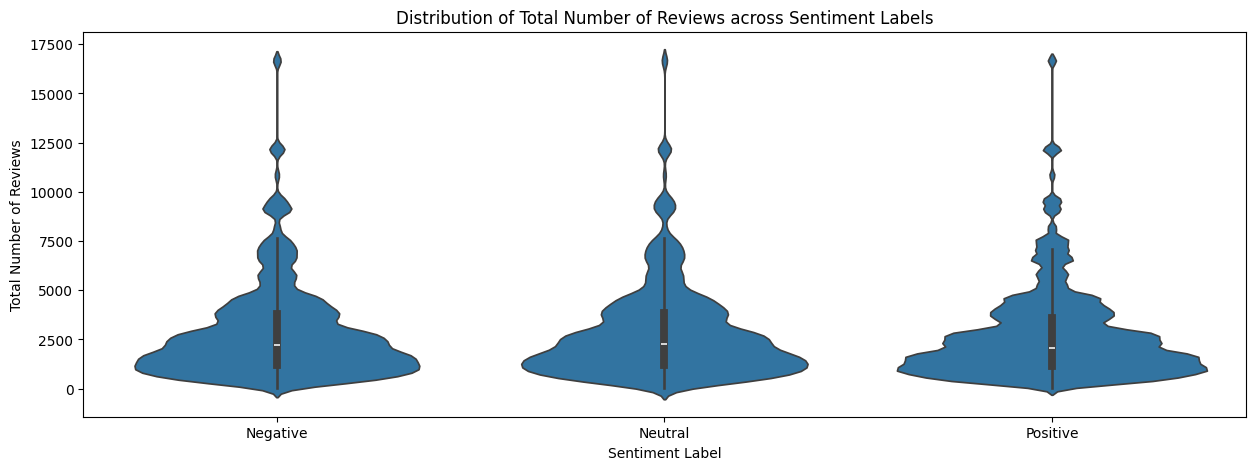

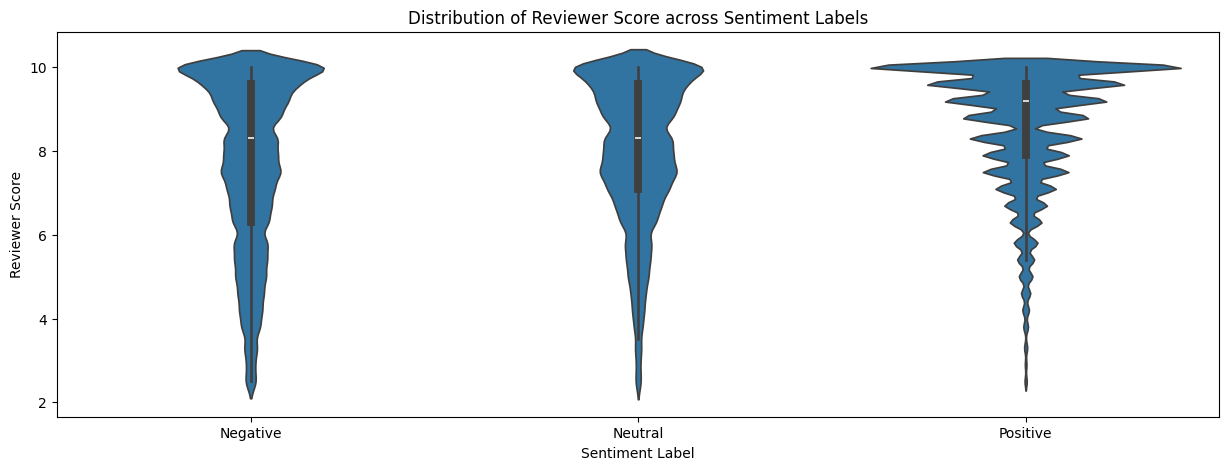

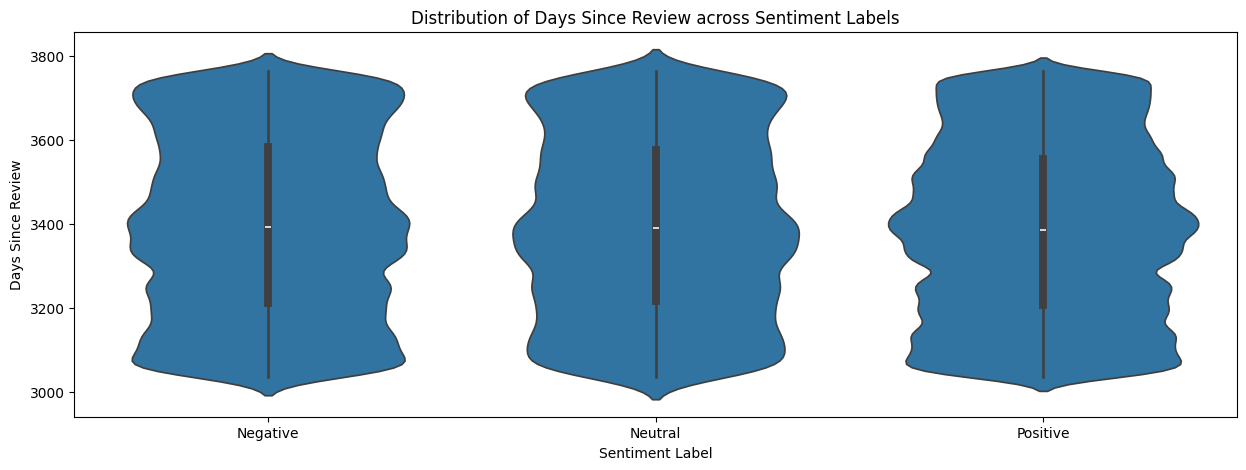

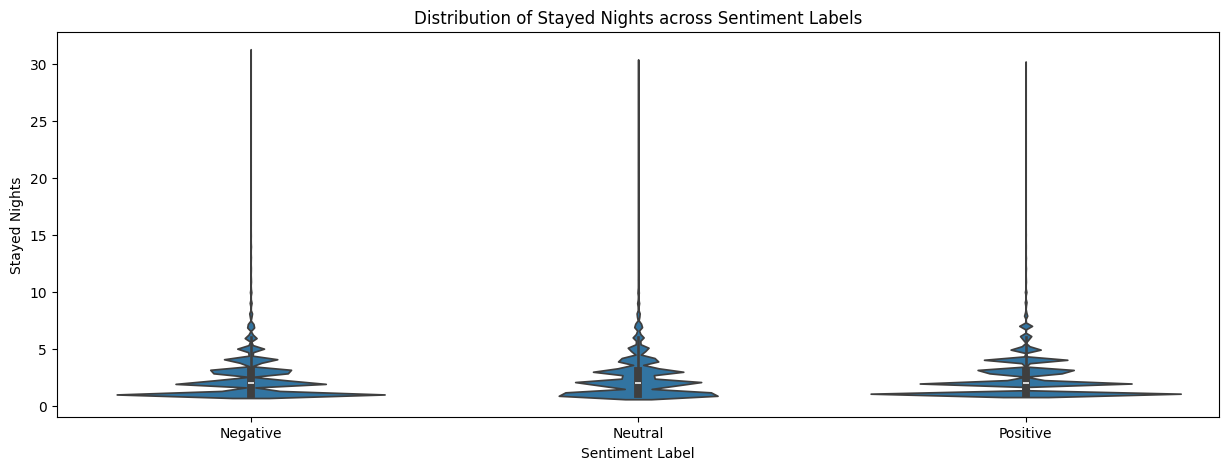

In [61]:
exclude = ["Sentiment_Compound", "Sentiment_Label_Int", "Total_Number_of_Reviews_Reviewer_Has_Given"]
for col in num_data:
    if col not in exclude:
        title_col = col.replace("_", " ")
        plt.figure(figsize=(15, 5))
        sns.violinplot(
            data=data,
            x="Sentiment_Label",
            y=col,
            inner="box"
        )
        plt.title(f"Distribution of {title_col} across Sentiment Labels")
        plt.xlabel("Sentiment Label")
        plt.ylabel(title_col)
        plt.show()

- Violin plots reveal most distributions largely overlap, despite statistically significant ANOVA results

- Reviewer scores show a slight separation: positive category has higher mean and wider spread, though all categories are heavily skewed toward the maximum

- Ceiling effect in dataset and limited discriminatory power of numerical attributes for distinguishing sentiment categories

C. CATEGORICAL <-> CATEGORICAL

Using Chi Square to test dependency between categorical attributes and target variable

Null Hypothesis (H₀): There is no statistically significant association between attribute and target variable

In [62]:
from scipy.stats import chi2_contingency

def chi_square_test(data, cat_cols, target="Sentiment_Label"):
    # build contingency table
    table = pd.crosstab(data[cat_cols], data[target])

    # run chi-square
    chi2, p, dof, expected = chi2_contingency(table)

    print(f"Chi-Square Test for: {cat_cols}")
    print("Chi2 Statistic:", chi2)
    print("Degrees of Freedom:", dof)
    print("p-value: {:.3e}".format(p))
    print("\nInterpretation:")
    if p < 0.05:
        print("Statistically significant association (reject H0)")
        print(f"{cat_cols} DOES affect sentiment distribution.\n")
    else:
        print("No Statistically significant association (fail to reject H0)")
        print(f"{cat_cols} DOES NOT affect sentiment distribution.\n")

for col in cat_cols:
    chi_square_test(data, col)

Chi-Square Test for: Hotel_Name
Chi2 Statistic: 11695.29103658121
Degrees of Freedom: 2982
p-value: 0.000e+00

Interpretation:
Statistically significant association (reject H0)
Hotel_Name DOES affect sentiment distribution.

Chi-Square Test for: Reviewer_Nationality
Chi2 Statistic: 7852.71205006749
Degrees of Freedom: 452
p-value: 0.000e+00

Interpretation:
Statistically significant association (reject H0)
Reviewer_Nationality DOES affect sentiment distribution.

Chi-Square Test for: Trip_Type
Chi2 Statistic: 1311.3249119545983
Degrees of Freedom: 4
p-value: 1.166e-282

Interpretation:
Statistically significant association (reject H0)
Trip_Type DOES affect sentiment distribution.

Chi-Square Test for: Group
Chi2 Statistic: 912.5353589319299
Degrees of Freedom: 8
p-value: 1.116e-191

Interpretation:
Statistically significant association (reject H0)
Group DOES affect sentiment distribution.



- Reviewer nationality exhibits very high cardinality - reflected in large degrees of freedom

- All cetegorical attributes tested show extremely small p-values - statistically significant associations with sentiment. Variation in sentiment distribution is systematically related to categorical attributes

Additional visualizations are used to examine class-level contributions

C:\Users\Admin\AppData\Local\Temp\ipykernel_1584\1529872953.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("Trip_Type")["Sentiment_Label"].value_counts(normalize=True).rename("Percentage").mul(100).reset_index()


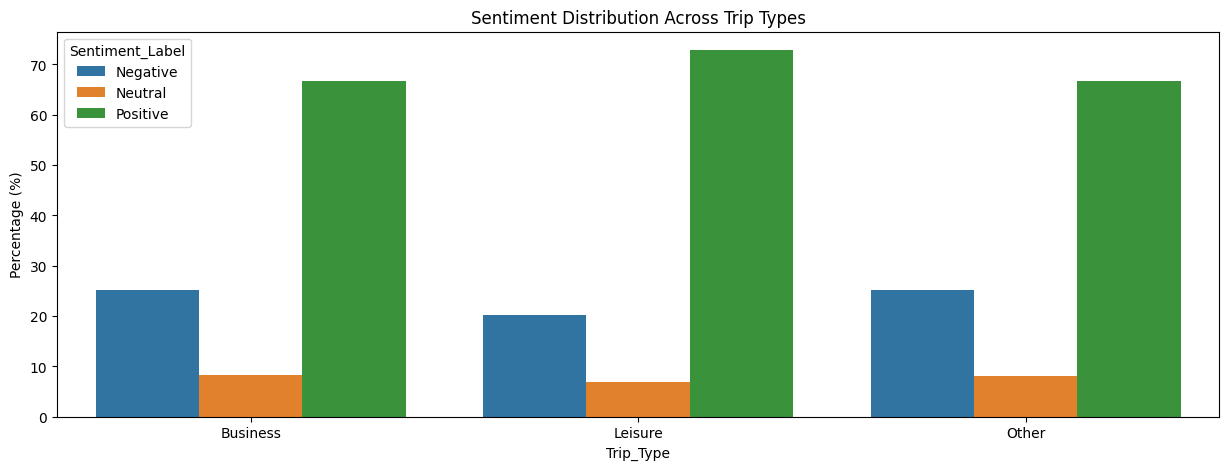

In [63]:
trip = (
    data.groupby("Trip_Type")["Sentiment_Label"].value_counts(normalize=True).rename("Percentage").mul(100).reset_index()
)
plt.figure(figsize=(15,5))
sns.barplot(
    data=trip,
    x="Trip_Type",
    y="Percentage",
    hue="Sentiment_Label"
)
plt.title("Sentiment Distribution Across Trip Types")
plt.ylabel("Percentage (%)")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1584\218030995.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("Group")["Sentiment_Label"].value_counts(normalize=True).rename("Percentage")


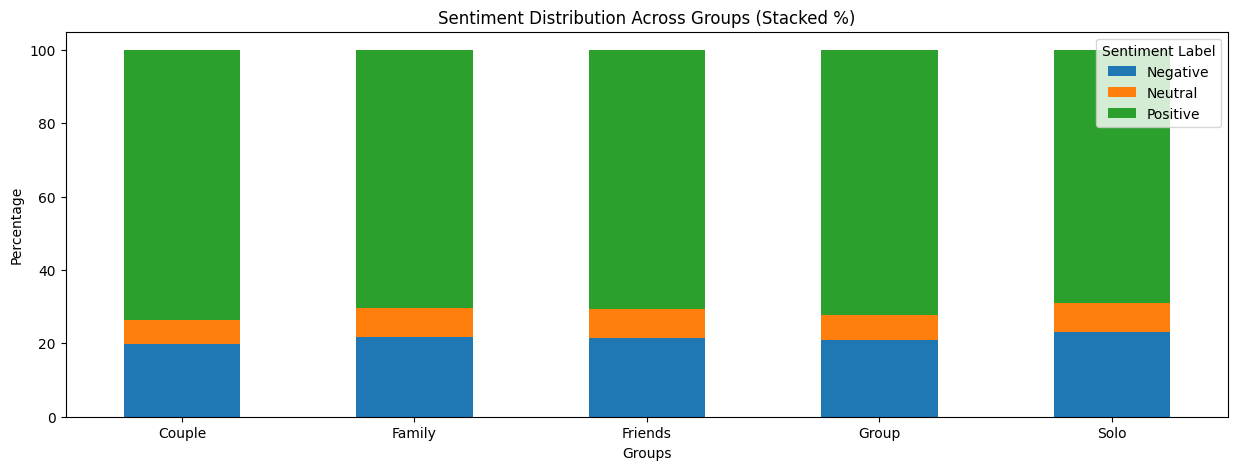

In [64]:
group = (
    data.groupby("Group")["Sentiment_Label"].value_counts(normalize=True).rename("Percentage")
    .mul(100).reset_index()
)

group_pivot = group.pivot(index="Group", columns="Sentiment_Label", values="Percentage", )

group_pivot.plot(kind="bar", stacked=True, figsize=(15,5))
plt.title("Sentiment Distribution Across Groups (Stacked %)")
plt.ylabel("Percentage")
plt.xlabel("Groups")
plt.legend(title="Sentiment Label")
plt.xticks(rotation=0)
plt.show()

- Chi-square tests indicate statistically significant association between trip type, groups and sentiment labels (p < 0.001). Though normalized sentiment distributions are roughly similar across different categories, highlighting the gap between statistical and practical significance in large datasets.

- Couples display the highest proportion of positive sentiment, while solo travelers exhibit the highest proportion of negative sentiment.

- Leisure trips are associated with a slightly higher proportion of positive sentiment compared to business and other trip types, indicating subtle but consistent effects on review sentiment.

D. TIME ANALYSIS

In [65]:
data["Stayed_Nights"].head

<bound method NDFrame.head of Review_Date
2015-08-04    1.0
2015-08-04    2.0
2015-08-04    4.0
2015-08-04    1.0
2015-08-04    1.0
             ... 
2017-08-03    3.0
2017-08-03    5.0
2017-08-03    2.0
2017-08-03    6.0
2017-08-03    6.0
Name: Stayed_Nights, Length: 515142, dtype: float64>

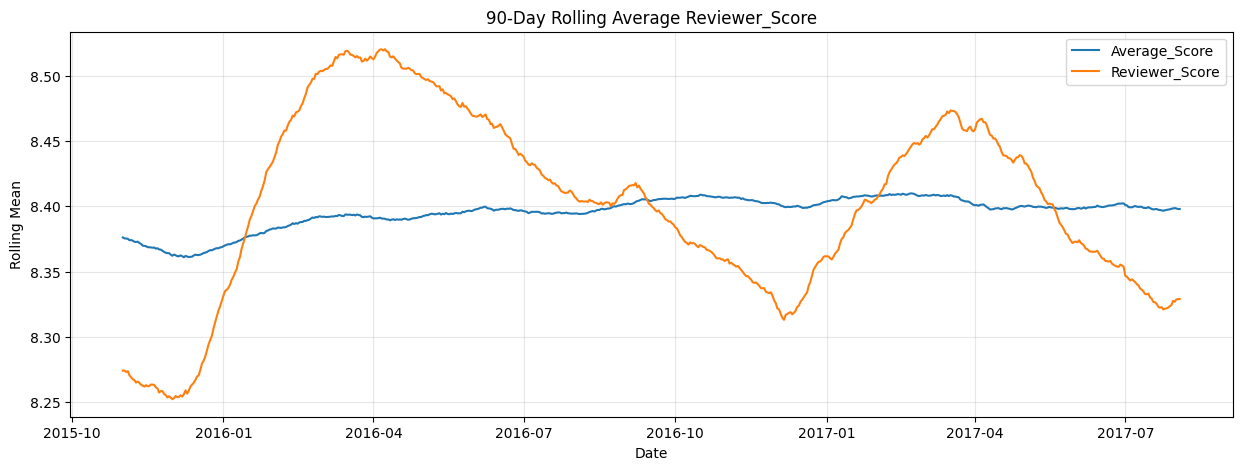

C:\Users\Admin\AppData\Local\Temp\ipykernel_1584\2617728633.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


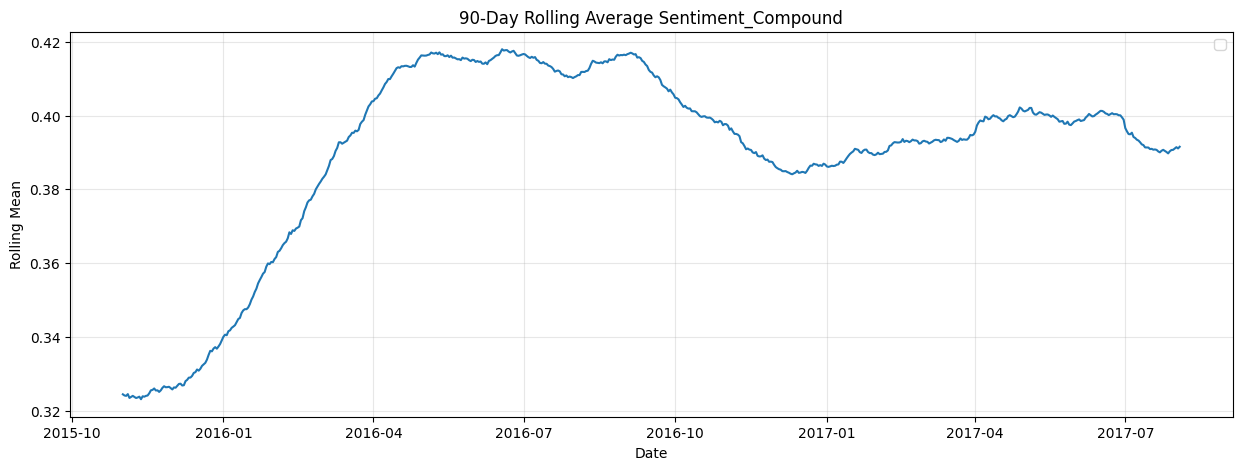

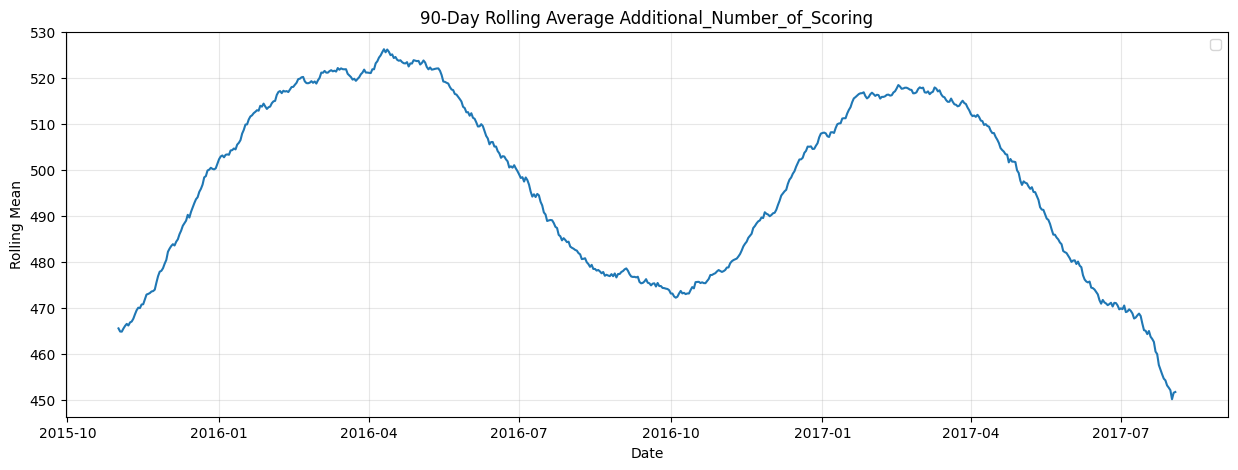

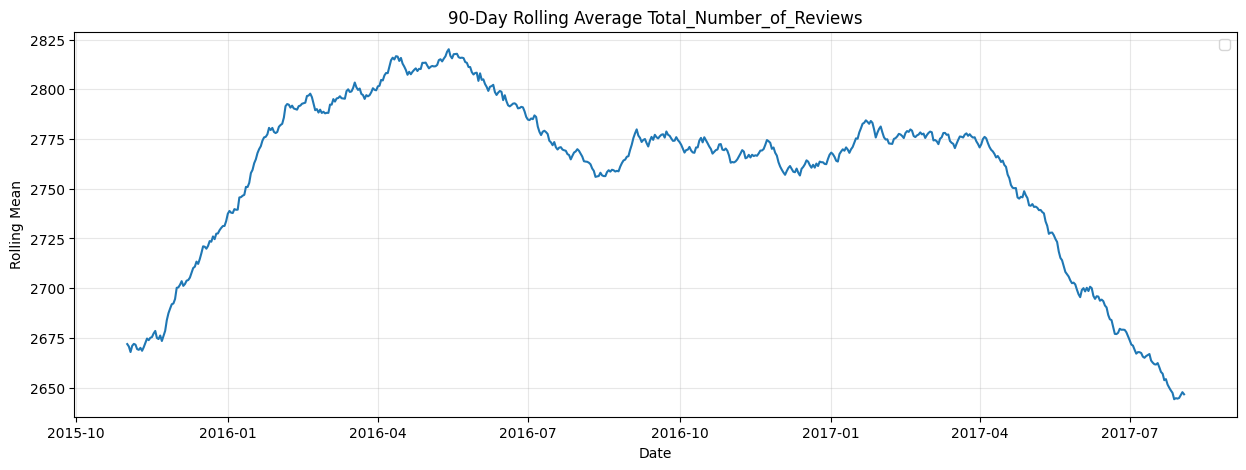

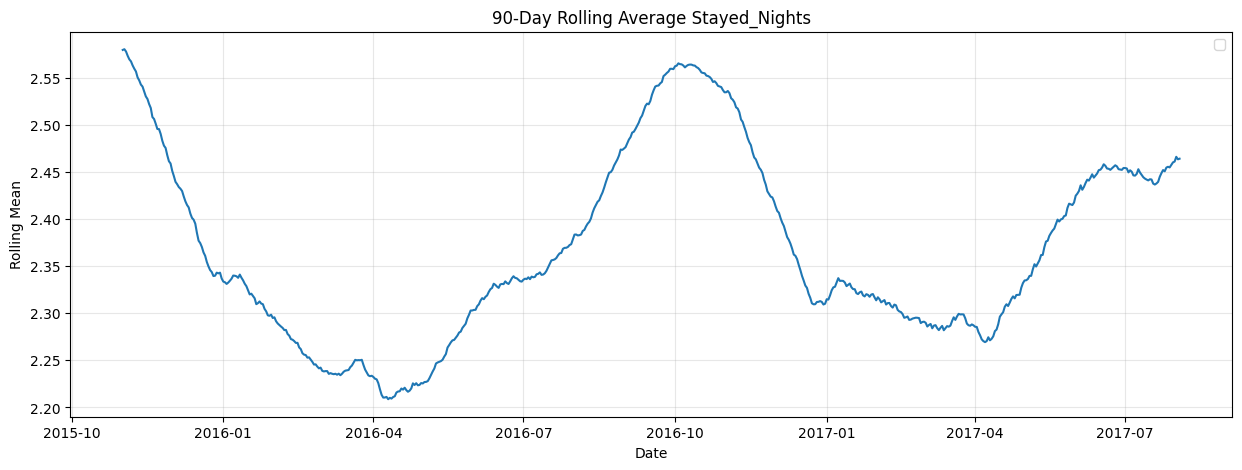

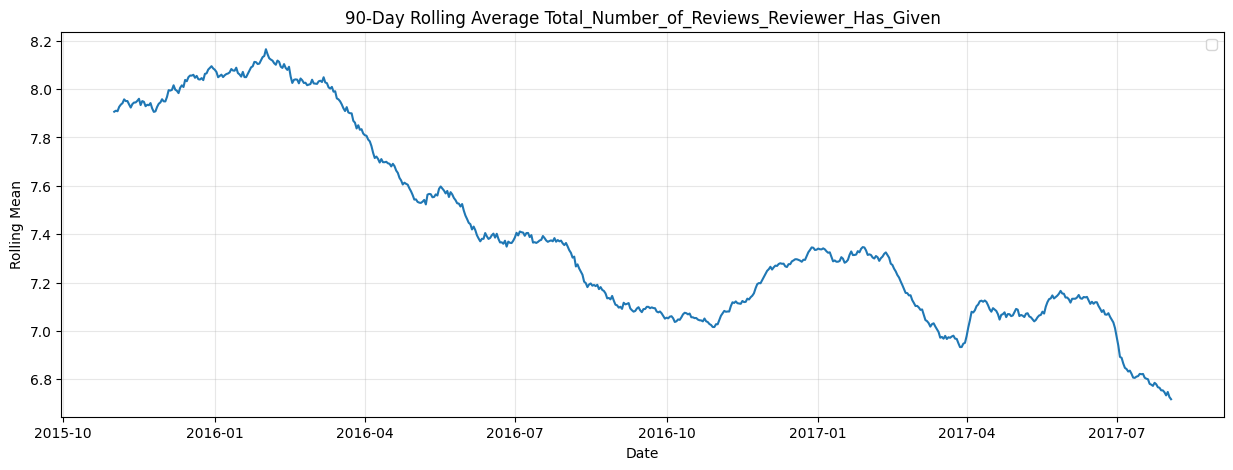

In [66]:
col_1 = ["Average_Score", "Reviewer_Score"]
col_2 = ["Sentiment_Compound", "Additional_Number_of_Scoring", "Total_Number_of_Reviews", "Stayed_Nights", "Total_Number_of_Reviews_Reviewer_Has_Given"]


daily = data.set_index("Review_Date").select_dtypes(include=["int64", "float64"]).resample("D").mean()
daily.columns
def plot_rolling(daily, cols, window):
    plt.figure(figsize=(15,5))

    rolled = daily[cols].rolling(window).mean()

    for col in cols:
        plt.plot(rolled.index, rolled[col], label=col)

    plt.title(f"{window}-Day Rolling Average {col}")
    plt.xlabel("Date")
    plt.ylabel("Rolling Mean")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_rolling(daily, col_1, window=90)

def plot_rolling_two(daily, cols, window):
    for col in cols:
        plt.figure(figsize=(15,5))
        plt.plot(daily.index, daily[col].rolling(window).mean())
        plt.title(f"{window}-Day Rolling Average {col}")
        plt.xlabel("Date")
        plt.ylabel("Rolling Mean")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

plot_rolling_two(daily, col_2, window=90)


- Attributes show closely related trajectories over dataset's timeframe. Notable improvements in customer volume, satisfaction, and sentiment leading up to April 2016 followed by simultaneous declines - an indication of interrelatedness between review activity, guest perceptions and sentiment.

- Contrastingly, Stayed Nights exhibits an inverse relationship relative to other variables. Despite this, overal magnitude of change of stayed nights is marginal, fluctuating within a narrow range of approximately 2.20 to 2.55 nights

- Total Number of Reviews Given by Reviewer displays subtle rises within the timeframe corresponding with changes in review activity, guest perceptions, and sentiment. This reflects an indirect but observable relationship.

Scoring and Sentiment Seasonality Analysis

Weekly, Monthly, and Yearly Patterns

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 515142 entries, 2015-08-04 to 2017-08-03
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                515142 non-null  int64         
 1   Review_Date                                 515142 non-null  datetime64[ns]
 2   Average_Score                               515142 non-null  float64       
 3   Hotel_Name                                  515142 non-null  category      
 4   Reviewer_Nationality                        515142 non-null  category      
 5   Total_Number_of_Reviews                     515142 non-null  int64         
 6   Total_Number_of_Reviews_Reviewer_Has_Given  515142 non-null  int64         
 7   Reviewer_Score                              515142 non-null  float64       
 8   Days_Since_Review                           515142 non-nul

In [81]:
daily["Month"] = daily.index.month
daily["Year"] = daily.index.year
daily["DayOfWeek"] = daily.index.dayofweek

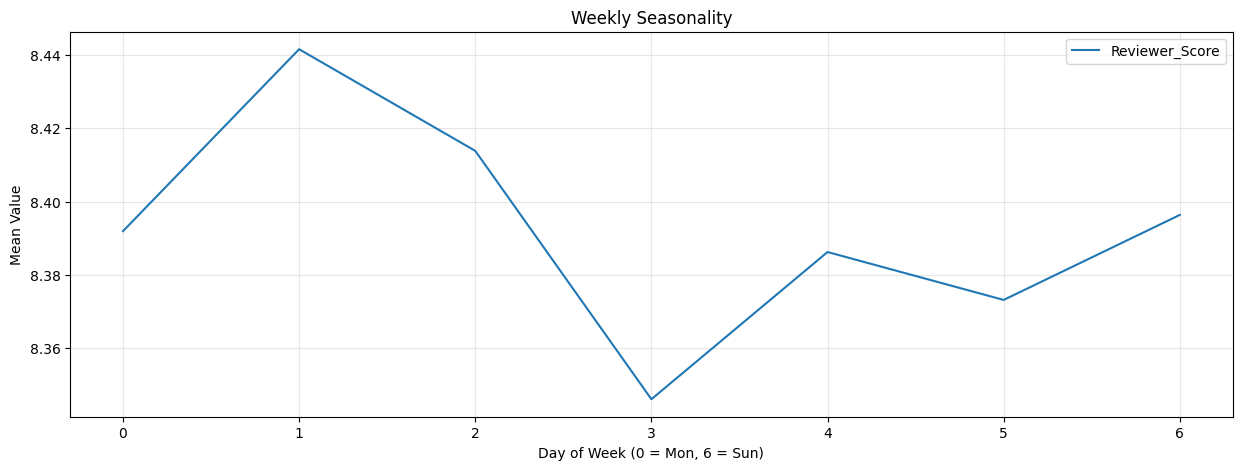

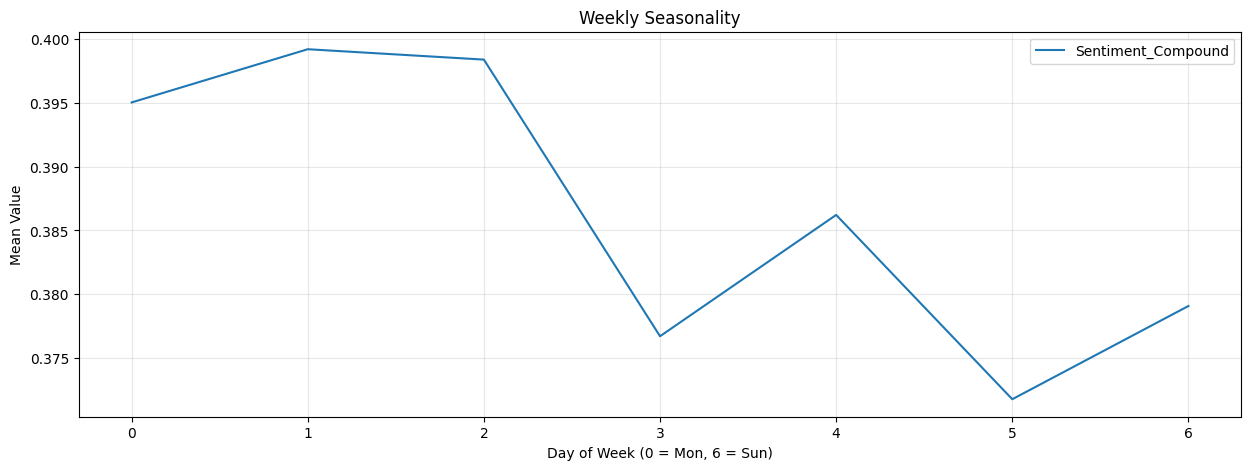

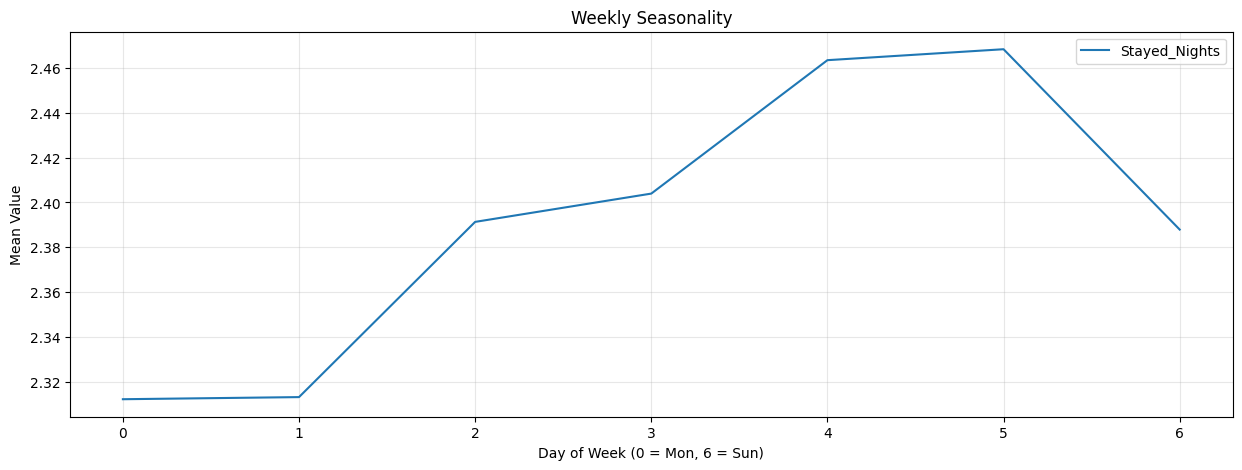

In [95]:
weekly_score = ["Reviewer_Score"]
weekly_sentiment = ["Sentiment_Compound"]
weekly_night = ["Stayed_Nights"]

def weekly_seasonality(cols):
    for col in cols:
        plt.figure(figsize=(15,5))
        plt.plot(daily.groupby("DayOfWeek")[col].mean(), label=col)
        plt.title(f"Weekly Seasonality")
        plt.xlabel("Day of Week (0 = Mon, 6 = Sun)")
        plt.ylabel("Mean Value")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

weekly_seasonality([weekly_score, weekly_sentiment, weekly_night])


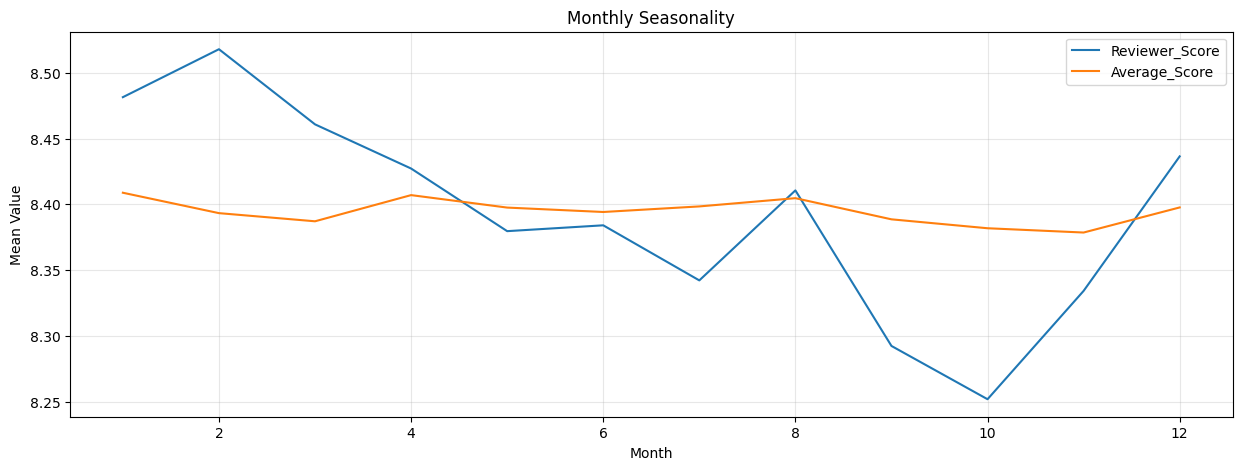

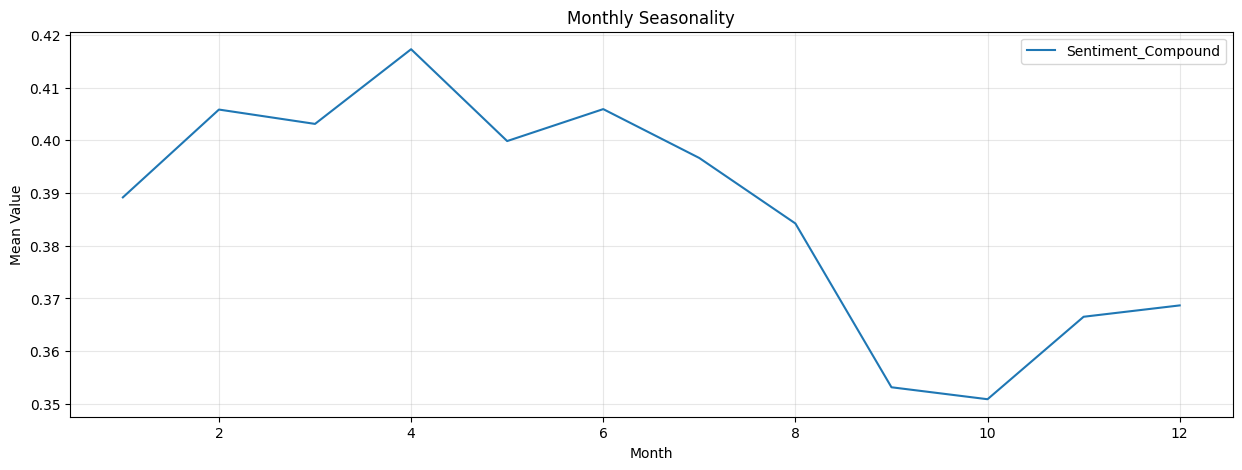

In [96]:
monthly_score_cols = ["Reviewer_Score", "Average_Score"]
monthly_sentiment_col = ["Sentiment_Compound"]

def monthly_seasonality(cols):
    for col in cols:
        plt.figure(figsize=(15,5))
        plt.plot(daily.groupby("Month")[col].mean(), label=col)
        plt.title(f"Monthly Seasonality")
        plt.xlabel("Month")
        plt.ylabel("Mean Value")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

monthly_seasonality([monthly_score_cols, monthly_sentiment_col])

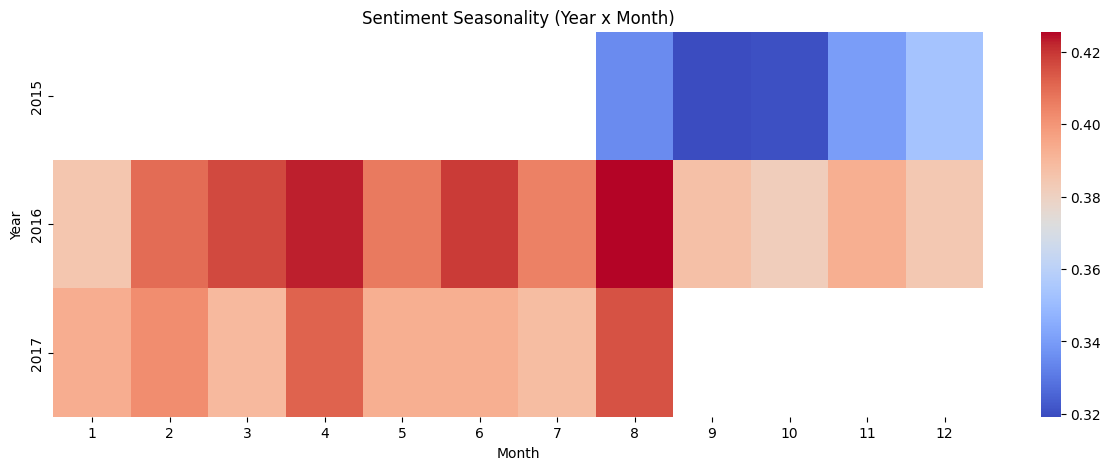

In [97]:
heat = daily.pivot_table(
    index="Year",
    columns="Month",
    values="Sentiment_Compound",
    aggfunc="mean"
)

plt.figure(figsize=(15,5))
sns.heatmap(heat, annot=False, cmap="coolwarm")
plt.title("Sentiment Seasonality (Year x Month)")
plt.show()

Weekly Patterns:
- Reviewer Score and Sentiment compound follow similar patterns. Tuesday achieves highest mean review score. Ratings decline sharply on Wednesday. While sentiment levels reach their lowest on Saturday, revealing a divergence between numerical ratings and expressed sentiment.

- Weekly stayed nights show on average customers usually spend more nights and check out by the weekends. This gives insight into low review scoring and sentiments during weekends, possibly as a result of high concentration of guests checking out.

Monthly Patterns:
- Reviewer scores and sentiment indicate weaker alignment based off of monthly analysis. Q1 and Q2 show the highest levels of perceived performance, whereas Q3 and early Q4 exhibit the lowest scores, with some recovery near year-end. The highest mean review scores occur in February, while sentiment peaks in April, though both measures share a common trough in October.

Sentiment Trends Over Time:
- Relatively low sentiment in late 2015, with a notable rise from February to April, followed by a steady decline toward the end of the year. These findings align with earlier rolling-average observations, reinforcing the consistency of the temporal patterns seen in customer sentiment.

Conclusion:

- Dataset displays unbalanced target variable categories with a dominant positive population.
- Disproportion in records counts due to lack of coverage of data time frame in 2015 and 2017, leaving majority of data from 2016

Exploratory analysis shows:

- Reviewers don't generally follow existing average ratings
- Difficulty of predicting sentiment from review scores alone
- Couple groups and leisure trips tend to display better sentiments
- Time analysis shows that sentiments are best during Q1 and Q2 and warm summer months until August. Meanwhile, guests seem to be more satisfied during the beginning of the week

Limitations:
- Statistical significance exist within statistical tests, however, due to the nature of large dataset, small differences between variables can already be accepted as significant. Practically, correlation tests and visual representation show that variables have little discrimnatory power for distinguishing sentiment categories.
- Numerical attributes of this dataset displays ceiling effect, reflected by generally high review scores, VADER-analyzed sentiments yielding overwhelming positivity class
- Lack of range of sentimentality analysis and categorization by VADER could limit the ability to capture guests' perception from written language

Sources: 
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.